**Part 2. AI Agent 활용 프로젝트**

- Chapter 01. 반복하고 수정하는 Agent

    - **📒[실습]** Clip 04. 코드 수정을 반복하는 데이터 분석 Agent

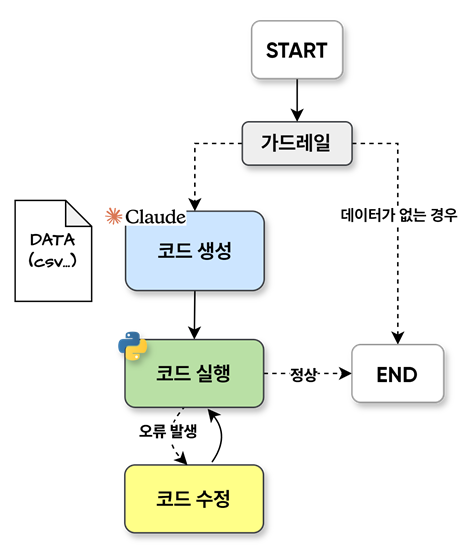

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

### 🗒️데이터 전처리 코드 작성을 위한 코드 수정 반복 Agent

실습 데이터 : 타이타닉 데이터셋 https://www.kaggle.com/competitions/titanic/overview

### Step 1. 데이터 전처리에 참고할 Context 제공하기 - tool

`describe()` : 데이터 개수, 평균, 표준편차, 최소/최대값, 4분위 (25%, 50%, 75%) 값을 포함한 통계 제공

In [2]:
from langchain_core.tools import tool
import pandas as pd


@tool
def describe_data(csv: str) -> str:
    """Describe the date column in the dataframe.

    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_str

In [3]:
tools = [describe_data]

In [4]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

llm_gpt = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm_gpt.bind_tools(tools, tool_choice="any")

In [5]:
response = llm_with_tools.invoke(
    "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv 이 데이터의 전처리를 해주세요."
)

In [6]:
response.tool_calls[0]['args']

{'csv': 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv'}

### Step 2. 코드 작성을 위한 프롬프트 + 구조화 코드 출력

In [7]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [8]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,

write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical columns, 
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.

Here is the describe result of the dataset:
\n ------- \n  {context} \n ------- \n

Do not wrap the code in a function and the response in any backticks or anything else. The code should be written as a flat script, so that it can be run immediately and any errors will be visible during execution.
Ensure any code you provide can be executed \n 
with all required imports and variables defined. Structure your answer with a description of the code solution. \n
Then list the imports. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE),
    ]
) 

In [9]:
from langchain_anthropic import ChatAnthropic

llm_claude= ChatAnthropic(model="claude-3-7-sonnet-20250219")

In [10]:
response.tool_calls[0]['args']

{'csv': 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv'}

In [11]:
tool_result = describe_data.invoke(response.tool_calls[0]['args'])

In [12]:
print(tool_result)

Data: https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv       Number of times pregnant  Plasma glucose concentration a 2 hours in an oral glucose tolerance test  Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  2-Hour serum insulin (mu U/ml)  Body mass index (weight in kg/(height in m)^2)  Diabetes pedigree function  Age (years)  Class variable
count                768.000000                                                                768.000000                        768.000000                        768.000000                      768.000000                                      768.000000                  768.000000   768.000000      768.000000
mean                   3.845052                                                                120.894531                         69.105469                         20.536458                       79.799479                                       31.992578                    0.471876    33.240885

In [13]:
generated_code = llm_claude.invoke(
    code_gen_prompt.format_messages(context=tool_result)
)
print("generated_code", generated_code)
code_structurer = llm_gpt.with_structured_output(code)
code_solution = code_structurer.invoke(generated_code.content)
print("code_solution", code_solution)

generated_code content='# Complete Data Preprocessing Solution for Diabetes Dataset\n\nThis code performs comprehensive preprocessing on the diabetes dataset, focusing on handling missing values, scaling numerical features, and preparing the data for machine learning.\n\nLooking at the descriptive statistics, I noticed several issues:\n1. Several columns have minimum values of 0, which are likely placeholders for missing data (e.g., blood pressure, skin thickness, insulin, BMI)\n2. The data needs scaling as features are on different scales\n3. There\'s a binary target variable (Class variable)\n\nThe solution below:\n- Imports the dataset\n- Replaces zeros with NaN in columns where zero is biologically implausible\n- Imputes missing values using median imputation (appropriate for medical data)\n- Scales features using StandardScaler\n- Creates train/test splits ready for modeling\n- Displays validation of preprocessing steps\n\n## Imports\n\n```python\nimport pandas as pd\nimport numpy

In [14]:
print(code_solution.imports)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
print(code_solution.code)

# Download the dataset
url = "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv"
df = pd.read_csv(url)

# Display original data info
print("Original Data Info:")
print(df.info())
print("\nSample data:")
print(df.head())

# Check for values that should be treated as missing
# In medical data, zeros in certain fields are biologically implausible
cols_with_zeros = ['Plasma glucose concentration a 2 hours in an oral glucose tolerance test', 
                   'Diastolic blood pressure (mm Hg)', 
                   'Triceps skin fold thickness (mm)', 
                   '2-Hour serum insulin (mu U/ml)', 
                   'Body mass index (weight in kg/(height in m)^2)']

# Count zeros in each column
print("\nNumber of zeros in each column (potential missing values):")
for col in cols_with_zeros:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} zeros")

# Replace zeros with NaN in columns where zeros are biologically implausible
for col in

### Step 3. Graph 생성하기

#### 1) State 생성하기

In [16]:
from langgraph.graph import StateGraph, MessagesState


class State(MessagesState): # messages 
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        context: Data summary
        generation : Code solution
        iterations : Number of tries
    """

    error: str # yes or no
    context: str
    generation: str
    iterations: int

graph_builder = StateGraph(State)

#### 2) 사용자 입력을 기반으로 데이터 Context 도구 호출을 결정하는 노드

In [17]:
from langchain_core.tools import tool
import pandas as pd


@tool
def describe_data(csv: str) -> str:
    """Describe the date column in the dataframe.

    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_str

In [18]:
llm_with_tools = llm_gpt.bind_tools(tools=[describe_data]) #, tool_choice="any"

In [19]:
def chatbot(state: State):
    print("##### HI ! #####")
    response = llm_with_tools.invoke(state["messages"])
    print("첫번째 LLM 호출 결과 : ", response)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

#### 3) 도구(tool) 호출 여부 기반 가드레일 노드 & 엣지 추가

In [20]:
def add_context(state: State):
    print("##### ADD CONTEXT #####")
    if messages := state.get("messages", []):
        message = messages[-1] # 마지막 message
    else:
        raise ValueError("No message found in input")

    for tool_call in message.tool_calls:
        for tool in tools:
            if tool.name == tool_call['name']:
                describe_str = tool.invoke(tool_call['args'])
    
    # Get context from describe_data tool
    print("데이터 통계 (context) : ", describe_str[:100])
    return {"context": describe_str}

graph_builder.add_node("add_context", add_context)

In [21]:
from langgraph.graph import END

def guardrail_route(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "add_context"
    return END


graph_builder.add_conditional_edges(
    "chatbot",
    guardrail_route,
    {"add_context": "add_context", END: END},
)

#### 4) 코드를 생성하는 노드

In [22]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [23]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,

write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical columns, 
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.

Here is the describe result of the dataset:
\n ------- \n  {context} \n ------- \n

Do not wrap the code in a function and the response in any backticks or anything else. The code should be written as a flat script, so that it can be run immediately and any errors will be visible during execution.
Ensure any code you provide can be executed \n 
with all required imports and variables defined. Structure your answer with a description of the code solution. \n
Then list the imports. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE),
    ]
) 

In [24]:
def generate(state: State):
    print("##### GENERATING CODE SOLUTION #####")

    context = state["context"]

    generated_code = llm_claude.invoke(
        code_gen_prompt.format_messages(context=context)
    )
    code_structurer = llm_gpt.with_structured_output(code)
    code_solution = code_structurer.invoke(generated_code.content)

    messages = [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    return {"generation": code_solution, "messages": messages}

graph_builder.add_node("generate", generate)

#### 5) 코드 정상 실행 여부를 확인하는 노드

In [25]:
def code_check(state: State):
    print("##### CHECKING CODE #####")

    code_solution = state["generation"]

    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        print("에러 메시지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        print("에러 메시지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "error": "no",
    }

graph_builder.add_node("code_check", code_check)

#### 6) 오류 메시지를 기반으로 코드를 재생성하는 노드

In [26]:
from langchain_core.prompts import ChatPromptTemplate

reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are given an error message that occurred while running a Python script, along with the original code that produced the error.
            Provide a corrected version of the original code that resolves the issue. 
            Ensure the code runs without errors and maintains the intended functionality."""
        ),
        ( 
            "user",           
            """
            --- ERROR MESSAGE ---
            {error}
            --- ORIGINAL CODE ---
            {code_solution}
            ----------------------

            Ensure any code you provide can be executed \n 
            with all required imports and variables defined. Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""",
        )
    ]
) 

In [27]:
def reflect(state: State):
    print("---REFLECTING CODE SOLUTION---")

    error = state["messages"][-1].content
    code_solution = state["generation"]
    code_solution = f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"

    corrected_code = llm_claude.invoke(reflect_prompt.format_messages(error=error, code_solution=code_solution))
    code_structurer = llm_gpt.with_structured_output(code)
    reflections = code_structurer.invoke(corrected_code.content)
    print("수정된 코드 : ", reflections)

    messages = [
        (
            "assistant",
            f"{reflections.prefix} \n Imports: {reflections.imports} \n Code: {reflections.code}",
        )
    ]

    return {"generation": reflections, "messages": messages, "iterations": state["iterations"] + 1}

graph_builder.add_node("reflect", reflect)

In [28]:
max_iterations = 5

In [29]:
def decide_to_finish(state: State):
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations: # 에러가 없거나 max_iterations에 도달하면 종료
        print("---DECISION: FINISH---")
        return "end"
    else: 
        print("---DECISION: RE-TRY SOLUTION---")
        return "reflect"

#### 7) Compile

In [30]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("add_context", "generate")
graph_builder.add_edge("generate", "code_check")
graph_builder.add_conditional_edges(
    "code_check",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect"
    },
)
graph_builder.add_edge("reflect", "code_check")

graph = graph_builder.compile()

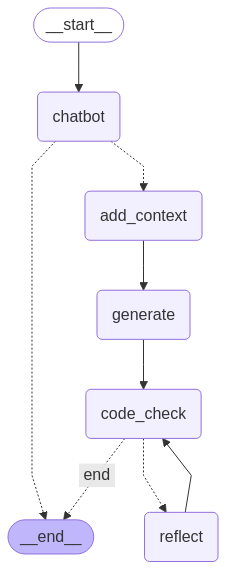

In [31]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [42]:
question = "titanic.csv 데이터의 전처리를 부탁합니다!"

In [ ]:
solution = graph.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

##### HI ! #####
첫번째 LLM 호출 결과 :  content='' additional_kwargs={'tool_calls': [{'id': 'call_pus5dxJz0uX5Yx5ULVbIqULd', 'function': {'arguments': '{"csv":"titanic.csv"}', 'name': 'describe_data'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 66, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BPTUNrkFgCncamvQPZfxk1JN0pKQA', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-7d424170-8f49-4072-be62-e0861cff7ad6-0' tool_calls=[{'name': 'describe_data', 'args': {'csv': 'titanic.csv'}, 'id': 'call_pus5dxJz0uX5Yx5ULVbIqULd', 'type': 'tool_call'}] usage_metadata={'input_tokens': 66, 'output_tokens': 18, 'total_tokens': 84, 'input_token_details': {'audio'

In [ ]:
print(solution["generation"].prefix,"\n")
print(solution["generation"].imports,"\n")
print(solution["generation"].code)